<a href="https://colab.research.google.com/github/manuaishika/softkmeans-nn/blob/main/imsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
Running quick demo...
Training for 30 epochs...
Epoch [ 10/30]: Total Loss: 0.5917, K-Means: 0.0457
Epoch [ 20/30]: Total Loss: 23.9023, K-Means: 0.0000
Epoch [ 30/30]: Total Loss: 151.0183, K-Means: 0.0000


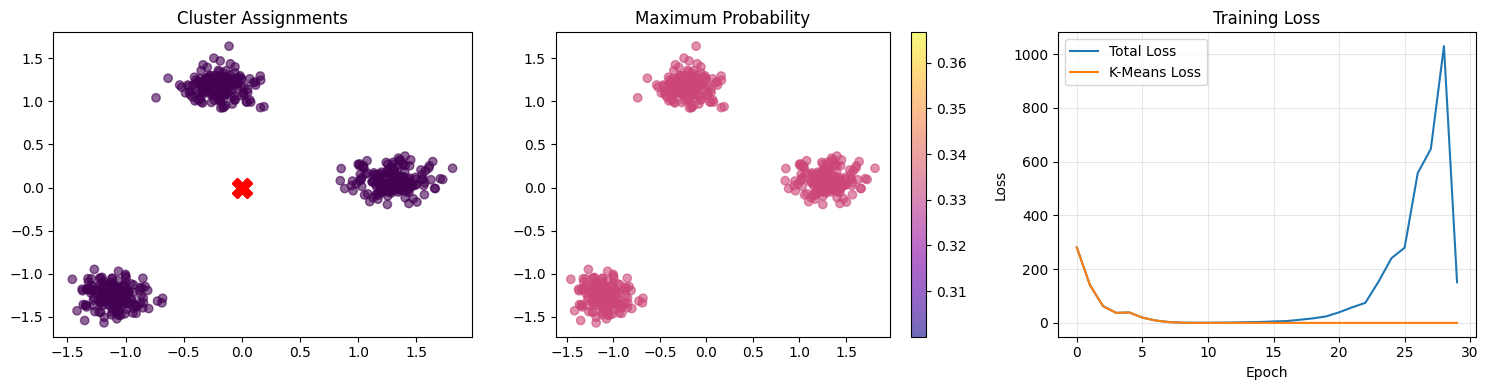

Cluster distribution: [  0   0 500]
Demo completed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

class SoftKMeansLayer(nn.Module):
    def __init__(self, input_dim, num_clusters, temperature=1.0):
        super().__init__()
        self.num_clusters = num_clusters
        self.temperature = temperature
        self.temperature_factor = nn.Parameter(torch.tensor([temperature]))
        self.centroids = nn.Parameter(torch.randn(num_clusters, input_dim) * 0.1)

    def forward(self, x):
        x_norm = (x ** 2).sum(dim=1, keepdim=True)
        c_norm = (self.centroids ** 2).sum(dim=1, keepdim=True).t()
        distances = x_norm + c_norm - 2 * torch.mm(x, self.centroids.t())
        logits = -distances / self.temperature_factor
        responsibilities = F.softmax(logits, dim=1)
        return responsibilities, distances

    def get_centroids(self):
        return self.centroids.data

class SoftKMeansNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_clusters, temperature=1.0):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*layers)
        self.soft_kmeans = SoftKMeansLayer(prev_dim, num_clusters, temperature)

    def forward(self, x):
        features = self.encoder(x)
        responsibilities, distances = self.soft_kmeans(features)
        return features, responsibilities, distances

    def predict(self, x):
        with torch.no_grad():
            _, responsibilities, _ = self.forward(x)
            return torch.argmax(responsibilities, dim=1)

    def get_centroids(self):
        return self.soft_kmeans.get_centroids()

    def get_soft_assignments(self, x):
        with torch.no_grad():
            _, responsibilities, _ = self.forward(x)
            return responsibilities

class SoftKMeansTrainer:
    def __init__(self, model, learning_rate=0.001, lambda_reg=0.01):
        self.model = model
        self.model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.lambda_reg = lambda_reg
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=10, factor=0.5
        )

    def kmeans_loss(self, responsibilities, distances):
        return torch.sum(responsibilities * distances)

    def entropy_regularization(self, responsibilities):
        entropy = -torch.sum(responsibilities * torch.log(responsibilities + 1e-10), dim=1)
        return torch.mean(entropy)

    def centroid_regularization(self):
        centroids = self.model.get_centroids()
        centroid_distances = torch.cdist(centroids, centroids, p=2)
        mask = ~torch.eye(centroid_distances.size(0), dtype=torch.bool).to(device)
        min_distance = torch.min(centroid_distances[mask])
        return 1.0 / (min_distance + 1e-10)

    def train_step(self, x_batch):
        self.optimizer.zero_grad()
        _, responsibilities, distances = self.model(x_batch)
        main_loss = self.kmeans_loss(responsibilities, distances)
        entropy_loss = self.entropy_regularization(responsibilities)
        reg_loss = self.centroid_regularization()
        total_loss = main_loss + 0.1 * entropy_loss + self.lambda_reg * reg_loss
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        return {
            'total_loss': total_loss.item(),
            'kmeans_loss': main_loss.item(),
            'entropy_loss': entropy_loss.item(),
            'reg_loss': reg_loss.item()
        }

    def train(self, data_loader, num_epochs=100, verbose=True):
        history = {
            'total_loss': [], 'kmeans_loss': [],
            'entropy_loss': [], 'reg_loss': []
        }
        for epoch in range(num_epochs):
            epoch_losses = {'total_loss': 0, 'kmeans_loss': 0,
                          'entropy_loss': 0, 'reg_loss': 0}
            for x_batch, _ in data_loader:
                x_batch = x_batch.to(device)
                losses = self.train_step(x_batch)
                for key in losses:
                    epoch_losses[key] += losses[key]
            for key in epoch_losses:
                epoch_losses[key] /= len(data_loader)
                history[key].append(epoch_losses[key])
            self.scheduler.step(epoch_losses['total_loss'])
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{num_epochs}]: "
                      f"Total Loss: {epoch_losses['total_loss']:.4f}, "
                      f"K-Means: {epoch_losses['kmeans_loss']:.4f}")
        return history

def create_dataset(dataset_type='blobs', n_samples=1000, n_clusters=4):
    if dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=0.8, random_state=42)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
        n_clusters = 2
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=42)
        n_clusters = 2
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    return X_tensor, y_tensor, data_loader, n_clusters

def visualize_results(X, predictions, soft_probs, centroids, history=None, title="Results"):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].scatter(X[:, 0], X[:, 1], c=predictions, cmap='tab20', alpha=0.6, s=30)
    axes[0,0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=300, linewidths=2, edgecolor='black')
    axes[0,0].set_title('Cluster Assignments')

    uncertainty = 1 - np.max(soft_probs, axis=1)
    axes[0,1].scatter(X[:, 0], X[:, 1], c=uncertainty, cmap='viridis', alpha=0.6, s=30)
    axes[0,1].set_title('Assignment Uncertainty')

    top2_diff = np.sort(soft_probs, axis=1)[:, -1] - np.sort(soft_probs, axis=1)[:, -2]
    axes[0,2].scatter(X[:, 0], X[:, 1], c=top2_diff, cmap='coolwarm', alpha=0.6, s=30)
    axes[0,2].set_title('Top 2 Probability Difference')

    if history is not None:
        axes[1,0].plot(history['total_loss'], label='Total Loss', linewidth=2)
        axes[1,0].plot(history['kmeans_loss'], label='K-Means Loss', linewidth=2)
        axes[1,0].set_title('Training Loss')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        axes[1,1].plot(history['entropy_loss'], label='Entropy Loss', color='green', linewidth=2)
        axes[1,1].plot(history['reg_loss'], label='Reg Loss', color='red', linewidth=2)
        axes[1,1].set_title('Auxiliary Losses')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    for cluster in range(soft_probs.shape[1]):
        axes[1,2].hist(soft_probs[:, cluster], bins=30, alpha=0.5, label=f'Cluster {cluster}')
    axes[1,2].set_title('Probability Distribution')
    axes[1,2].set_xlabel('Probability')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    if predictions is not None:
        print(f"Silhouette Score: {silhouette_score(X, predictions):.4f}")

def run_experiment(dataset_type='blobs', n_samples=1000, hidden_dims=[32, 16], num_epochs=100):
    X, y_true, data_loader, n_clusters = create_dataset(
        dataset_type=dataset_type,
        n_samples=n_samples,
        n_clusters=4 if dataset_type == 'blobs' else 2
    )

    model = SoftKMeansNN(
        input_dim=X.shape[1],
        hidden_dims=hidden_dims,
        num_clusters=n_clusters,
        temperature=0.5
    )

    trainer = SoftKMeansTrainer(model, learning_rate=0.001, lambda_reg=0.01)
    print(f"Training on {dataset_type} dataset...")
    history = trainer.train(data_loader, num_epochs=num_epochs, verbose=True)

    with torch.no_grad():
        predictions = model.predict(X).cpu().numpy()
        soft_probs = model.get_soft_assignments(X).cpu().numpy()
        centroids = model.get_centroids().cpu().numpy()

    visualize_results(
        X.cpu().numpy(),
        predictions,
        soft_probs,
        centroids,
        history,
        title=f"{dataset_type.capitalize()} Dataset"
    )

    return model, predictions, history

def quick_demo():
    print("Running quick demo...")
    X_tensor, y_true, data_loader, n_clusters = create_dataset(
        dataset_type='blobs',
        n_samples=500,
        n_clusters=3
    )

    model = SoftKMeansNN(
        input_dim=2,
        hidden_dims=[10],
        num_clusters=n_clusters,
        temperature=0.3
    )

    trainer = SoftKMeansTrainer(model, learning_rate=0.01)
    print("Training for 30 epochs...")
    history = trainer.train(data_loader, num_epochs=30, verbose=True)

    predictions = model.predict(X_tensor).cpu().numpy()
    soft_probs = model.get_soft_assignments(X_tensor).cpu().numpy()
    centroids = model.get_centroids().cpu().numpy()

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(X_tensor.cpu()[:, 0], X_tensor.cpu()[:, 1], c=predictions, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.title("Cluster Assignments")

    plt.subplot(1, 3, 2)
    plt.scatter(X_tensor.cpu()[:, 0], X_tensor.cpu()[:, 1], c=np.max(soft_probs, axis=1), cmap='plasma', alpha=0.6)
    plt.title("Maximum Probability")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['kmeans_loss'], label='K-Means Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Cluster distribution: {np.bincount(predictions)}")
    print("Demo completed!")

def run_all_experiments():
    dataset_types = ['blobs', 'moons', 'circles']
    results = {}
    for dataset_type in dataset_types:
        if dataset_type == 'blobs':
            hidden_dims = [16, 8]
        else:
            hidden_dims = [32, 16, 8]

        print(f"\nRunning {dataset_type} dataset...")
        model, predictions, history = run_experiment(
            dataset_type=dataset_type,
            n_samples=1000,
            hidden_dims=hidden_dims,
            num_epochs=80
        )
        results[dataset_type] = {'model': model, 'predictions': predictions, 'history': history}
    return results

if __name__ == "__main__":
    quick_demo()